_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [0]:
import pandas as pd

# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

In [0]:
#Libraries
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
df['shot_made_flag'].value_counts()/len(df['shot_made_flag'])
baseline=0.527081

If we guessed the majority class for every prediction, we would have a baseline accuracy of 0.527081 by guessing that we'll miss all shots.

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [5]:
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2018-10-01')
train_all = df[df['game_date'] < cutoff]
test  = df[df['game_date'] >= cutoff]
train_all.shape, test.shape

# Check test data shape
assert test.shape == (1709, 20)

train_all.shape, test.shape

((12249, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [6]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [7]:

#double checking for missing values
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [8]:
def engineer_features(df):
  
  #Homecourt Advantage: Is the home team (htm) the Golden State Warriors (GSW) ?
  df['homecourt_adv']= np.where(df['htm'] =='GSW',1,0)
  
  #Opponent: Who is the other team playing the Golden State Warriors?
  df['opponent']=np.where(df['htm'] !='GSW',df['htm'],df['vtm'])
  
  #Seconds remaining in the period: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
  df['secs_in_period']=df['minutes_remaining']*60+df['seconds_remaining']
  
  #Seconds remaining in the game: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
  df['secs_in_game']=np.where(df['period']>=4,df['secs_in_period'],(4-df['period'])*(12*60)+df['secs_in_period'])
  
    
  return df

train_all=engineer_features(train_all)
test =engineer_features(test)

print(train_all.shape, test.shape)
train_all.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(12249, 24) (1709, 24)


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_adv,opponent,secs_in_period,secs_in_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,685,2845
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,HOU,571,2731
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,HOU,362,2522
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,HOU,589,2029
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,HOU,139,1579


In [9]:
#how many periods do we have in the data
df.period.unique()

array([1, 2, 4, 3, 5, 6])

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [10]:
cutoff = pd.to_datetime('2017-10-01')
train= train_all[train_all['game_date'] < cutoff]
val = train_all[train_all['game_date'] >= cutoff]

# Check test data shape
assert val.shape == (1168, 24)


train.shape, val.shape


((11081, 24), (1168, 24))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [11]:
#looking at categorical variables for cardinality
df.describe(exclude = 'number').T.sort_values(by = 'unique')

,count,unique,top,freq,first,last
player_name,13958,1,Stephen Curry,13958,NaN,NaN
shot_type,13958,2,2PT Field Goal,7135,NaN,NaN
season_type,13958,2,Regular Season,11846,NaN,NaN
shot_zone_range,13958,5,24+ ft.,6721,NaN,NaN
shot_zone_area,13958,6,Center(C),5987,NaN,NaN
shot_zone_basic,13958,7,Above the Break 3,5695,NaN,NaN
htm,13958,32,GSW,6871,NaN,NaN
vtm,13958,32,GSW,7087,NaN,NaN
action_type,13958,53,Jump Shot,6657,NaN,NaN
game_date,13958,801,2013-05-06 00:00:00,35,2009-10-28 00:00:00,2019-06-05 00:00:00


In [12]:
df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [0]:
# The status_group column is the target
target = 'shot_made_flag'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 54].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [15]:

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['player_name', 'action_type', 'shot_type',
                                     'shot_zone_basic', 'shot_zone_area',
                                     'shot_zone_range', 'htm', 'vtm',
                                     'season_type', 'opponent'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=Non

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [16]:
# score on val
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print ('Improvement vs Baseline', accuracy_score(y_val, y_pred)-baseline)

Validation Accuracy 0.5967465753424658
Improvement vs Baseline 0.06966557534246576


In [0]:
#new_baseline
baseline=0.5967465753424658

#Improvement

In [0]:
#wrangling data
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['game_date'].dt.year
    X['month_recorded'] = X['game_date'].dt.month
    X['day_recorded'] = X['game_date'].dt.day
    X = X.drop(columns='game_date')
        
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['player_name']
    X = X.drop(columns=unusable_variance)
    
    return X

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [19]:
# The status_group column is the target
target = 'shot_made_flag'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 54].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]
# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print ('Improvement vs Baseline', accuracy_score(y_val, y_pred)-baseline)

Validation Accuracy 0.5976027397260274
Improvement vs Baseline 0.0008561643835616195


In [0]:
#New Baseline
baseline=0.5976027397260274

In [21]:
#graphing relationship between shots taken and location
import plotly.express as px
px.scatter(train, x='loc_x', y='loc_y', color='shot_made_flag', opacity=0.5, title='Shots Made by Location')


In [0]:
#no noticeable preferred spot.

In [49]:
train.head()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecourt_adv,opponent,secs_in_period,secs_in_game,year_recorded,month_recorded,day_recorded
0,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,1,HOU,685,2845,2009,10,28
1,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,1,HOU,571,2731,2009,10,28
2,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,1,HOU,362,2522,2009,10,28
3,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,1,HOU,589,2029,2009,10,28
4,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,1,HOU,139,1579,2009,10,28


In [53]:
pd.crosstab(train['action_type'], train['shot_made_flag'],normalize=True,margins=True)


shot_made_flag,0,1,All
action_type,,,
Alley Oop Layup shot,0.000000,0.000090,0.000090
Cutting Finger Roll Layup Shot,0.000271,0.001715,0.001985
Cutting Layup Shot,0.000902,0.005234,0.006137
Driving Bank Hook Shot,0.000000,0.000090,0.000090
Driving Bank shot,0.000993,0.003068,0.004061
Driving Dunk Shot,0.000090,0.000541,0.000632
Driving Finger Roll Layup Shot,0.004873,0.021117,0.025990
Driving Floating Bank Jump Shot,0.000271,0.001173,0.001444
Driving Floating Jump Shot,0.001895,0.002617,0.004512


In [34]:
#changing encoding
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print ('Improvement vs Baseline', accuracy_score(y_val, y_pred)-baseline)

Validation Accuracy 0.6001712328767124
Improvement vs Baseline 0.0025684931506849695


In [0]:
#New Baseline
baseline=0.6001712328767124

In [38]:
#Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use RandomizedSearchCV or do it manually
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(random_state=32)
)

param_distributions = {
    'randomforestclassifier__min_samples_leaf': randint(1, 5),
    'randomforestclassifier__n_estimators': randint(30, 500), 
    'randomforestclassifier__max_depth': [ 10, 20,30,40,50,60, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   50.4s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished


In [39]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.6088939595613413, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 174}
Cross-validation Accuracy -0.6179045212525945


In [44]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(n_estimators=174,
                           max_depth=10,
                           max_features= 0.6088939595613413,
                           min_samples_leaf= 3,
                           random_state=32, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
print ('Improvement vs Baseline', accuracy_score(y_val, y_pred)-baseline)

Validation Accuracy 0.6147260273972602
Improvement vs Baseline 0.0


In [0]:
#new baseline
baseline=0.6147260273972602

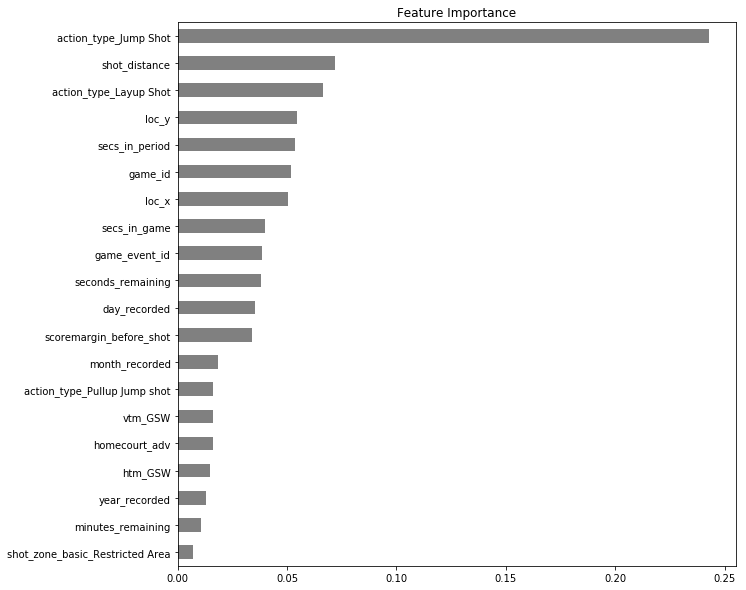

In [47]:
#Get and plot your model's feature importances.

rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)


n = 20
plt.figure(figsize=(10, 10))
plt.title('Feature Importance')
importances.sort_values()[-n:].plot.barh(color='grey');


## 7. Get your model's test accuracy

> (One time, at the end.)

In [48]:
y_pred = pipeline.predict(X_test)
print('Validation Accuracy', accuracy_score(y_test, y_pred))
print ('Improvement vs Validation', accuracy_score(y_test, y_pred)-baseline)

Validation Accuracy 0.620245757753072
Improvement vs Validation 0.005519730355811769


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [24]:
Correct_Predictions=85+36
Total_Predictions=85+58+8+36
accuracy = Correct_Predictions / Total_Predictions
print(accuracy)

0.6470588235294118


### Calculate precision

In [25]:
#Precision for positives
true_positives=36
selected_items=58+36
precision = true_positives/selected_items
print(precision)

0.3829787234042553


### Calculate recall

In [26]:
relevant_elements=36+8
recall= true_positives/relevant_elements
print(recall)

0.8181818181818182


### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.
